In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import xgboost as xgb
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, recall_score
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams["figure.facecolor"] = 'FFFFFF'
matplotlib.rcParams['figure.dpi'] = 100

Wczytywanie danych

In [2]:
original_data = pd.read_excel('online_retail_II.xlsx', [0, 1])
original_data = pd.concat([original_data[0], original_data[1]], ignore_index=True)

In [39]:
data = original_data.copy()

In [40]:
data['Cancelled'] = (original_data['Invoice'].str[0] == 'C')
print(json.dumps(list(data.columns), indent=4))

[
    "Invoice",
    "StockCode",
    "Description",
    "Quantity",
    "InvoiceDate",
    "Price",
    "Customer ID",
    "Country",
    "Cancelled"
]


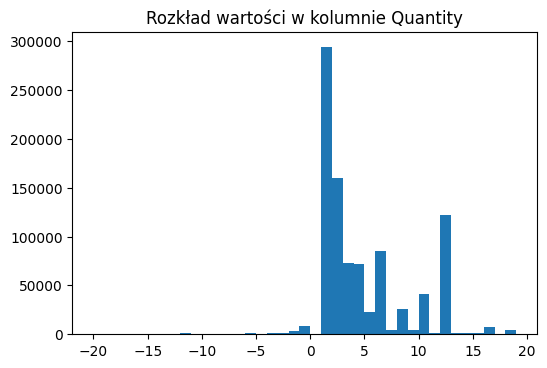

In [41]:
plt.hist(data['Quantity'], bins=list(range(-20, 20, 1)))
plt.title("Rozkład wartości w kolumnie Quantity");

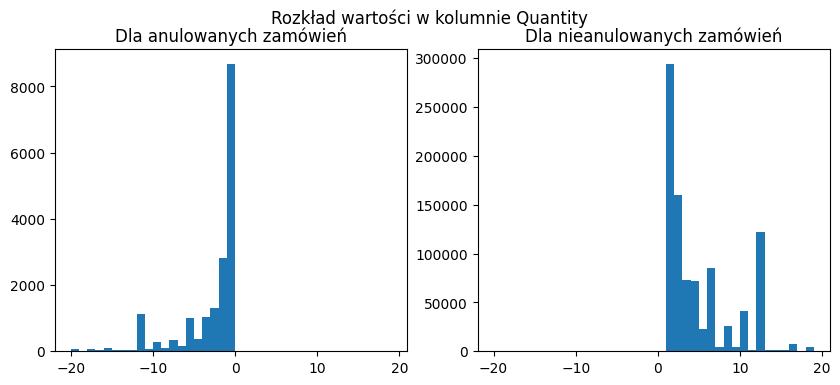

In [42]:
_, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle("Rozkład wartości w kolumnie Quantity")
axes[0].set_title("Dla anulowanych zamówień")
axes[0].hist(data[data['Cancelled']]['Quantity'], bins=list(range(-20, 20, 1)));

axes[1].set_title("Dla nieanulowanych zamówień")
axes[1].hist(data[~data['Cancelled']]['Quantity'], bins=list(range(-20, 20, 1)));

In [43]:
data['Quantity'] = data['Quantity'].abs()

In [44]:
data.isna().any()

Invoice        False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
Price          False
Customer ID     True
Country        False
Cancelled      False
dtype: bool

In [45]:
nan_number = data['Customer ID'].isna().value_counts()[True]
data['Customer ID'] = data['Customer ID'].fillna(-1)
print(f"Replaced {nan_number} NaNs with -1")

Replaced 243007 NaNs with -1


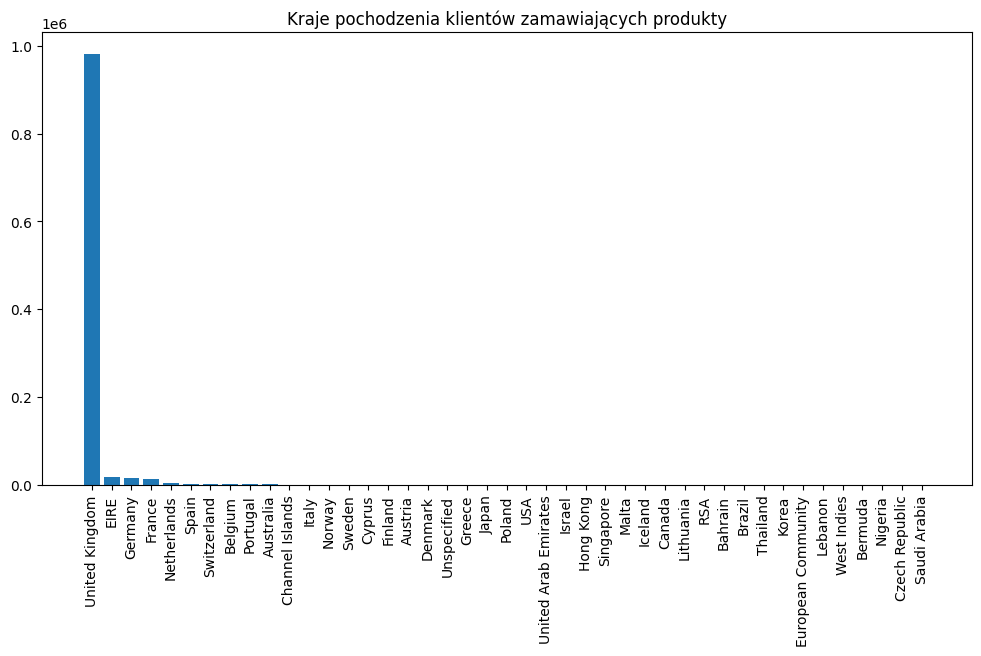

In [46]:
countries = data['Country'].value_counts().to_dict()
plt.figure(figsize=(12, 6))
plt.bar(list(countries.keys()), height=list(countries.values()))
plt.xticks(*plt.xticks(), rotation=90)
plt.title("Kraje pochodzenia klientów zamawiających produkty");

In [47]:
duplicate_amounts = [0 for _ in range(30)]

for group_name, group in data.groupby(by=['StockCode', 'Quantity', 'Price', 'Customer ID']):
    if True in group['Cancelled'].values:
        try:
            not_cancelled = group['Cancelled'].value_counts()[False]
        except KeyError:
            not_cancelled = 0
        while len(duplicate_amounts) <= not_cancelled:
            duplicate_amounts.append(0)
        duplicate_amounts[not_cancelled] += group['Cancelled'].value_counts()[True]

0.384 z anulowanych produktów ma nieanulowany odpowiednik


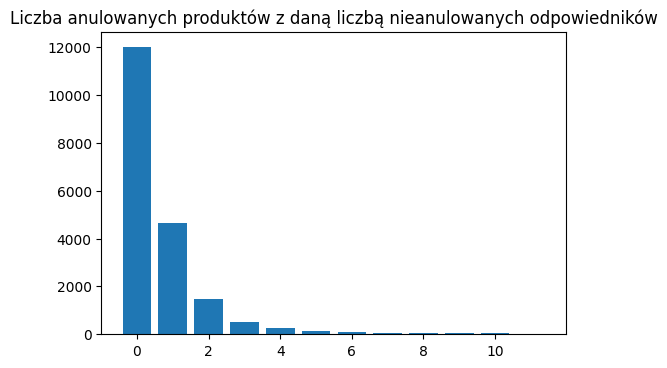

In [48]:
plt.bar(list(range(12)), duplicate_amounts[:12])
plt.title("Liczba anulowanych produktów z daną liczbą nieanulowanych odpowiedników")
print(f"{sum(duplicate_amounts[1:]) / sum(duplicate_amounts):.3f} z anulowanych produktów ma nieanulowany odpowiednik")

In [49]:
grouped_data = data.groupby('Invoice')

In [50]:
aggregated = {
    "Invoice": [],
    "EarliestInvoiceDate": [],
    "Cancelled": [],
    "Customer ID": []
}

for group_name, df_group in grouped_data:
    if all(df_group['StockCode'].isin(['M', 'm', 'S', 'B', 'D'])):
        continue
    assert not any(df_group['StockCode'] == 'S')

    products = ~df_group['StockCode'].isin(['M', 'm', 'D'])

    aggregated['Invoice'].append(group_name)
    
    assert all(df_group['Customer ID'] == df_group['Customer ID'].iloc[0])
    aggregated['Customer ID'].append(df_group['Customer ID'].iloc[0])
    
    group_invoice_dates = df_group['InvoiceDate'].sort_values()
    aggregated['EarliestInvoiceDate'].append(group_invoice_dates.iloc[0])

    aggregated['Cancelled'].append(str(group_name)[0] == 'C')

In [51]:
aggregated["Manual"] = []
aggregated["Discount"] = []
aggregated["ManualSum"] = []
aggregated["DiscountSum"] = []

for group_name, df_group in grouped_data:
    if all(df_group['StockCode'].isin(['M', 'm', 'S', 'B', 'D'])):
        continue

    aggregated['Manual'].append(0)
    aggregated['Discount'].append(0)
    aggregated['ManualSum'].append(0)
    aggregated['DiscountSum'].append(0)

    stock_code_idx = list(df_group.columns).index('StockCode')
    price_idx = list(df_group.columns).index('Price')
    quantity_idx = list(df_group.columns).index('Price')
    
    for row in df_group.values:
        if row[stock_code_idx] in {'M', 'm'}:
            aggregated['Manual'][-1] += 1
            aggregated['ManualSum'][-1] += row[price_idx] * row[quantity_idx]
        elif row[stock_code_idx] == 'D':
            aggregated['Discount'][-1] += 1
            aggregated['DiscountSum'][-1] += row[price_idx] * row[quantity_idx]

In [52]:
aggregated["isBritish"] = []
aggregated["TotalQuantity"] = []
aggregated["PriceSum"] = []
aggregated["DifferentProducts"] = []

for group_name, df_group in grouped_data:
    if all(df_group['StockCode'].isin(['M', 'm', 'S', 'B', 'D'])):
        continue

    products = ~df_group['StockCode'].isin(['M', 'm', 'D'])

    aggregated['isBritish'].append(df_group['Country'].iloc[0] == 'United Kingdom')
    aggregated['PriceSum'].append((df_group['Price'] * df_group['Quantity']).sum())
    aggregated['TotalQuantity'].append(df_group['Quantity'].sum())
    aggregated['DifferentProducts'].append(products.value_counts()[True])
        
    aggregated['PriceSum'][-1] -= aggregated['DiscountSum'][-1] * 2

In [53]:
aggregated["MostCommonProdQuantity"] = []
aggregated["MostCommonProdPrice"] = []
aggregated["MostExpensiveProdQuantity"] = []
aggregated["MostExpensiveProdPrice"] = []

for group_name, df_group in grouped_data:
    if all(df_group['StockCode'].isin(['M', 'm', 'S', 'B', 'D'])):
        continue
    products = ~df_group['StockCode'].isin(['M', 'm', 'D'])
    
    sorted_by_quantity = df_group[products].sort_values(by='Quantity', ascending=False)
    aggregated["MostCommonProdQuantity"].append(sorted_by_quantity['Quantity'].iloc[0])
    aggregated["MostCommonProdPrice"].append(sorted_by_quantity['Price'].iloc[0])

    sorted_by_prices = df_group[products].sort_values(by='Price', ascending=False)
    aggregated["MostExpensiveProdQuantity"].append(sorted_by_prices['Quantity'].iloc[0])
    aggregated["MostExpensiveProdPrice"].append(sorted_by_prices['Price'].iloc[0])

In [54]:
aggregated_data = pd.DataFrame(aggregated)
print(json.dumps(list(aggregated_data.columns), indent=4))

[
    "Invoice",
    "EarliestInvoiceDate",
    "Cancelled",
    "Customer ID",
    "Manual",
    "Discount",
    "ManualSum",
    "DiscountSum",
    "isBritish",
    "TotalQuantity",
    "PriceSum",
    "DifferentProducts",
    "MostCommonProdQuantity",
    "MostCommonProdPrice",
    "MostExpensiveProdQuantity",
    "MostExpensiveProdPrice"
]


In [55]:
duplicate_amounts = [0 for _ in range(30)]

for group_name, group in aggregated_data.groupby(by=['TotalQuantity', 'PriceSum', 'Customer ID']):
    if True in group['Cancelled'].values:
        try:
            not_cancelled = group['Cancelled'].value_counts()[False]
        except KeyError:
            not_cancelled = 0
        while len(duplicate_amounts) <= not_cancelled:
            duplicate_amounts.append(0)
        duplicate_amounts[not_cancelled] += group['Cancelled'].value_counts()[True]

0.146 spośród zamówień zostało anulowane


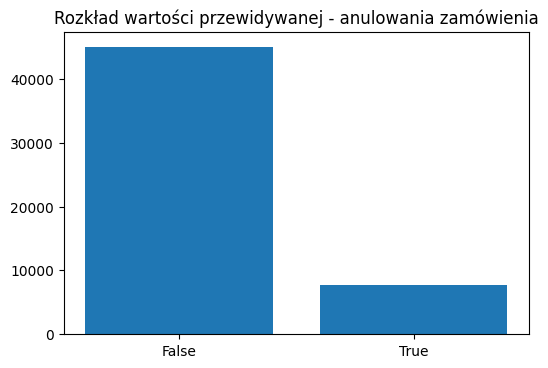

In [76]:
cancels = aggregated_data['Cancelled'].value_counts().values
plt.bar([False, True], cancels)
plt.xticks([0, 1], ['False', 'True'])
plt.title('Rozkład wartości przewidywanej - anulowania zamówienia')
print(f"{cancels[1] / cancels.sum():.3f} spośród zamówień zostało anulowane")

0.060 z anulowanych zamówień ma nieanulowany odpowiednik


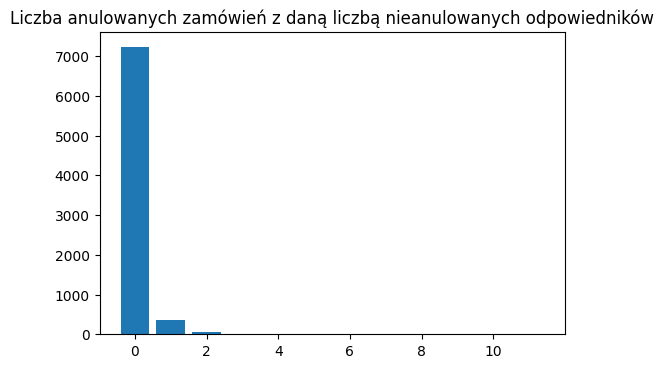

In [57]:
plt.bar(list(range(12)), duplicate_amounts[:12])
plt.title("Liczba anulowanych zamówień z daną liczbą nieanulowanych odpowiedników")
print(f"{sum(duplicate_amounts[1:]) / sum(duplicate_amounts):.3f} z anulowanych zamówień ma nieanulowany odpowiednik")

In [58]:
print(f"{len(aggregated_data)=}")
# aggregated_data = old_agg_data.drop_duplicates(subset=['PriceSum', 'TotalQuantity'], keep=False, inplace=True)
aggregated_data.sort_values(by='EarliestInvoiceDate', ascending=True, inplace=True)
print(f"{len(aggregated_data)=}")

len(aggregated_data)=52734
len(aggregated_data)=52734


In [59]:
ready_data = aggregated_data.drop(columns=['Invoice', 'EarliestInvoiceDate', 'Customer ID'])
ready_data['InvoiceDate'] = aggregated_data['EarliestInvoiceDate'].dt.dayofyear
ready_data['InvoiceHour'] = aggregated_data['EarliestInvoiceDate'].dt.hour

In [66]:
# train_data, test_data = train_test_split(ready_data, test_size=0.2, random_state=421)
train_data, test_data = ready_data[:len(ready_data) // 5 * 4], ready_data[len(ready_data) // 5 * 4:]

print(f"{len(train_data)=}")
print(f"{len(test_data)=}")

train_X, train_y = train_data.drop(columns=['Cancelled']), train_data['Cancelled']
dtrain = xgb.DMatrix(train_X, train_y)
test_X, test_y = test_data.drop(columns=['Cancelled']), test_data['Cancelled']
all_X, all_y = ready_data.drop(columns=['Cancelled']), ready_data['Cancelled']

len(train_data)=42184
len(test_data)=10550


In [67]:
params = dict(
    objective='binary:logistic',
    n_jobs=8,
    eta=0.1,
    gamma=0,
    max_depth=6,
    min_child_weight=1,
    subsample=1,
    sampling_method='uniform',
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_lambda=1,
    reg_alpha=2,
    tree_method='exact',
    scale_pos_weight=1,
    refresh_leaf=1,
    process_type='default'
)

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    nfold=5,
    stratified=True,
    early_stopping_rounds=50,
    as_pandas=True,
    verbose_eval=False
)
model = xgb.XGBClassifier(**params, n_estimators=cv_results['test-logloss-mean'].argmin())
model.fit(train_X, train_y)
pred = model.predict(test_X)

In [70]:
print(f"{cohen_kappa_score(test_y, pred)=}")
print(f"{accuracy_score(test_y, pred)=}")
print(f"{recall_score(test_y, pred)=}")

cohen_kappa_score(test_y, pred)=0.6837224343461736
accuracy_score(test_y, pred)=0.9296682464454976
recall_score(test_y, pred)=0.6979913916786227


Ostateczny model (wytrenowany na całym zbiorze):

In [ ]:
model = xgb.XGBClassifier(**params, n_estimators=cv_results['test-logloss-mean'].argmin())
model.fit(all_X, all_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=208, n_jobs=8, num_parallel_tree=None,
              predictor=None, ...)

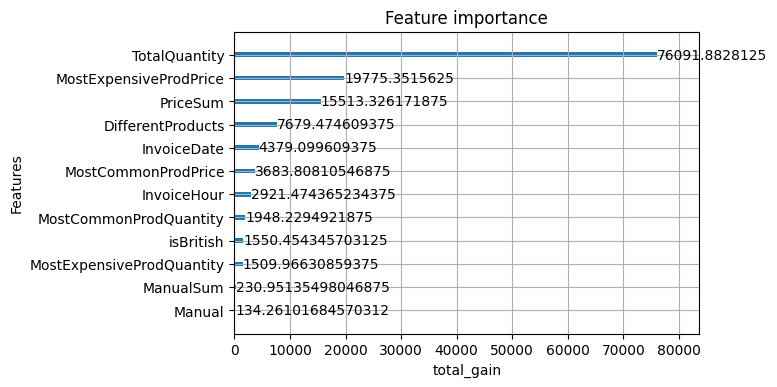

In [ ]:
xgb.plot_importance(model, importance_type='total_gain', xlabel='total_gain');